# Homework 3

## Solutions by: Zak M, Riccardo G, and Nick Lewis

## 1. Define Optimization Goals

The goal is to optimize a pairs trading strategy by maximizing the Sharpe Ratio. By optimizing this ratio, the strategy aims to achieve the best possible balance between profitability and stability.

For simplicity and computational efficiency, we are focusing our analysis on the IT sector of the S&P stocks. For our final we will compare this to a benchmark IT ETF.

## 2. Identify Parameters

- Entry Threshold: The z-score level that triggers a trade. When the z-score exceeds this threshold (either positively or negatively), the strategy initiates a position. This parameter determines how selective the strategy is when identifying trading opportunities.

- Exit Threshold: The z-score level at which the strategy exits a position. A lower exit threshold allows the strategy to close trades conservatively, limiting exposure to adverse price movements.

- Rolling Window Size: The number of days used to calculate the rolling hedge ratio and spread. This affects how sensitive the model is to recent price changes and the accuracy of the z-score calculation.

## 3. Set Parameter Ranges

We define the following range for optimization:

Entry Threshold: 1.5 to 3.0 with step size of 0.5. We start at 1.5 to avoid trading normal market noise.
Exit Threshold: 0.3 to 1.0 with a step size: 0.2
Rolling Window Size: 14 to 42 days with step size of 7 days

## 4. Choose an Optimization Method

Given the size of the parameter space, we will use a grid search optimization method to systematically test all possible combinations of parameters. 

## 5. Perform Optimization

Using the product function, we generate all combinations of entry_threshold, exit_threshold, and rolling_window.

For each parameter set, the strategy calculates the spread and z-score between the two stocks in a cointegrated pair and generates trading signals (long/short entry and exits) based on the thresholds. Then, it adjusts positions dynamically and calculates daily strategy returns.
The parameter combination with the highest Sharpe Ratio is stored for each cointegrated pair.


In our final project, we aim to refine our position sizing and focus on a systematic way of find the top pairs to focus our strategy on. We also want to add nuances like stop loss orders to analyze how we can further improve downside risks. For further generality of our approach, we aim to find optimal parameters mentioned above on training tests up to 2022, and seeing how forward testing those strategies performed to present date since 2023. In doing so, we are confident we can generate stronger results than this preliminary research. 

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from itertools import product
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [6]:
def get_sector_tickers(sectors_to_include=None, sectors_to_exclude=None):
    sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')
    sp500_sectors = sp500_df[['Symbol', 'GICS Sector']]

    if sectors_to_include:
        sp500_sectors = sp500_sectors[sp500_sectors['GICS Sector'].isin(sectors_to_include)]
    if sectors_to_exclude:
        sp500_sectors = sp500_sectors[~sp500_sectors['GICS Sector'].isin(sectors_to_exclude)]

    return sp500_sectors.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

def find_cointegrated_pairs(data, pairs, significance_level=0.05):
    coint_pairs = []
    pvalues = []
    for pair in tqdm(pairs, desc="Testing Cointegration"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        result = ts.coint(s1, s2)
        pvalue = result[1]
        if pvalue < significance_level:
            coint_pairs.append(pair)
            pvalues.append(pvalue)
    return coint_pairs, pvalues

def evaluate_strategy(data, pair, entry, exit, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        long_entries = zscore < -entry
        long_exits = zscore > -exit
        short_entries = zscore > entry
        short_exits = zscore < exit

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)

        for t in range(len(zscore)):
            if long_entries.iloc[t]:
                positions_S1.iloc[t] = 1
                positions_S2.iloc[t] = -hedge_ratios.iloc[t]
            elif short_entries.iloc[t]:
                positions_S1.iloc[t] = -1
                positions_S2.iloc[t] = hedge_ratios.iloc[t]
            elif long_exits.iloc[t] or short_exits.iloc[t]:
                positions_S1.iloc[t] = 0
                positions_S2.iloc[t] = 0
            else:
                if t > 0:
                    positions_S1.iloc[t] = positions_S1.iloc[t - 1]
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio
    except Exception as e:
        return None, None
    

def parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, rolling_windows):
    best_sharpe = -np.inf
    best_strategy = None
    best_params = None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(evaluate_strategy, data, pair, entry, exit, window): (entry, exit, window)
            for entry, exit, window in product(entry_thresholds, exit_thresholds, rolling_windows)
        }

        for future in concurrent.futures.as_completed(futures):
            entry, exit, window = futures[future]
            try:
                strategy_returns, sharpe = future.result()
                if sharpe is not None and sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_strategy = strategy_returns
                    best_params = (entry, exit, window)
            except Exception as e:
                print(f"Error optimizing pair {pair} with params ({entry}, {exit}, {window}): {e}")

    return best_strategy, best_params, best_sharpe

In [7]:
START = "2015-01-01"
END = "2023-12-31"

included_sectors = ["Information Technology"] 
sector_tickers = get_sector_tickers(sectors_to_include=included_sectors)

print("Sector Tickers Loaded:")
for sector, tickers in sector_tickers.items():
    print(f"{sector}: {len(tickers)} tickers")

data = pd.DataFrame()
for sector, tickers in sector_tickers.items():
    for ticker in tqdm(tickers, desc=f"Downloading {sector}"):
        try:
            df = yf.download(ticker, start=START, end=END, progress=False)
            if not df.empty:
                data[ticker] = df['Adj Close']
        except Exception as e:
            print(f"Could not download {ticker}: {e}")

data.dropna(axis=1, inplace=True)

corr_matrix = data.corr().abs()

high_corr_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.9)
cointegrated_pairs, pvalues = find_cointegrated_pairs(data, high_corr_pairs)

coint_df = pd.DataFrame({
    'Pair': cointegrated_pairs,
    'P-Value': pvalues
}).sort_values('P-Value')

print("Top Cointegrated Pairs:")
print(coint_df.head(10))

if coint_df.empty:
    print("No cointegrated pairs found. Exiting...")
    exit()

Sector Tickers Loaded:
Information Technology: 69 tickers


Testing Cointegration: 100%|██████████| 591/591 [00:36<00:00, 16.02it/s]

Top Cointegrated Pairs:
             Pair   P-Value
48   (CDNS, SNPS)  0.000005
38   (AAPL, MPWR)  0.000026
40   (AMAT, NXPI)  0.000039
2     (ACN, INTU)  0.000085
101    (TER, TYL)  0.000099
9     (ADBE, CRM)  0.000245
18     (AMD, NOW)  0.000246
25     (ADI, CDW)  0.000453
46   (CDNS, KLAC)  0.000892
93   (QRVO, SWKS)  0.000899


In [ ]:
entry_thresholds = np.arange(1.5, 3.1, 0.5)
exit_thresholds = np.arange(0.3, 1.1, 0.2)
rolling_windows = range(14, 43, 7)

all_strategy_returns = pd.DataFrame()
best_results = []

# Parallel optimization for each cointegrated pair
for pair in tqdm(cointegrated_pairs, desc="Optimizing Pairs"):
    best_strategy, best_params, best_sharpe = parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, rolling_windows)

    if best_strategy is not None:
        all_strategy_returns[pair] = best_strategy
        best_results.append((pair, *best_params, best_sharpe))

# Display best results
best_results_df = pd.DataFrame(best_results, columns=['Pair', 'Entry Threshold', 'Exit Threshold', 'Rolling Window', 'Sharpe Ratio'])
print("Top Results Across All Pairs:")
print(best_results_df.sort_values('Sharpe Ratio', ascending=False))

In [10]:
display(best_results_df.sort_values('Sharpe Ratio', ascending=False))

,Pair,Entry Threshold,Exit Threshold,Rolling Window,Sharpe Ratio
28,"(ADI, MSFT)",2.5,0.5,21,1.029571
1,"(ACN, CDW)",2.0,0.5,35,0.973168
47,"(CDNS, ORCL)",1.5,0.3,35,0.957422
25,"(ADI, CDW)",2.0,0.3,14,0.947820
0,"(ACN, AMD)",1.5,0.3,14,0.877410
...,...,...,...,...,...
51,"(CDW, MSFT)",2.5,0.3,21,0.062813
22,"(APH, MPWR)",1.5,0.3,21,0.061089
94,"(QCOM, NOW)",2.5,0.5,14,-0.021581
63,"(JBL, NVDA)",2.0,0.5,14,-0.031056


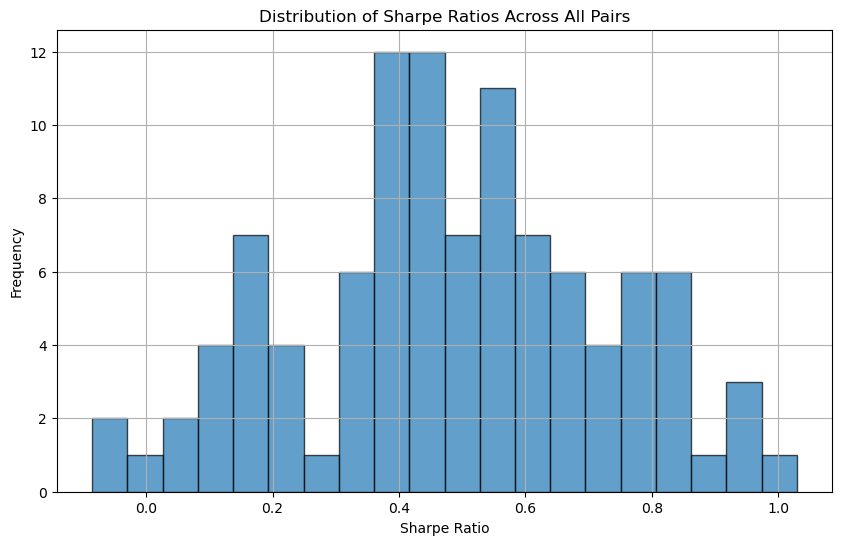

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(best_results_df['Sharpe Ratio'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sharpe Ratios Across All Pairs')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Generalization of Strategy Performance based on Average returns across each pair:

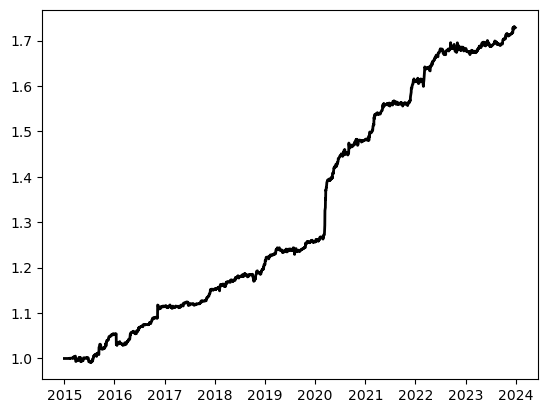

In [16]:
portfolio_returns = all_strategy_returns.mean(axis=1)
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot portfolio cumulative returns
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio', color='black', linewidth=2)

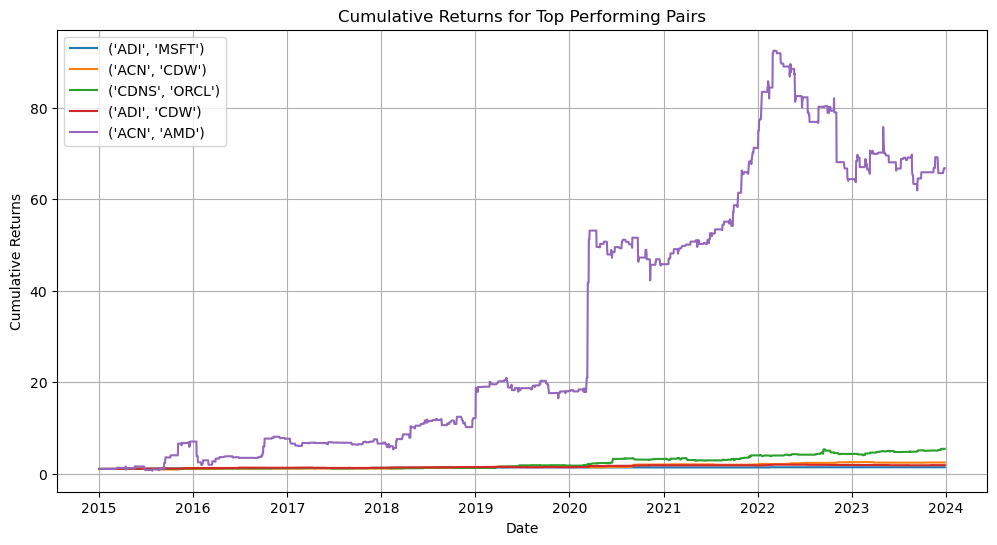

In [17]:
top_pairs = best_results_df.sort_values('Sharpe Ratio', ascending=False).head(5)['Pair']
plt.figure(figsize=(12, 6))

for pair in top_pairs:
    pair_cumulative_returns = (1 + all_strategy_returns[pair]).cumprod()
    plt.plot(pair_cumulative_returns, label=f"{pair}")

plt.title('Cumulative Returns for Top Performing Pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


Z-Score Analysis

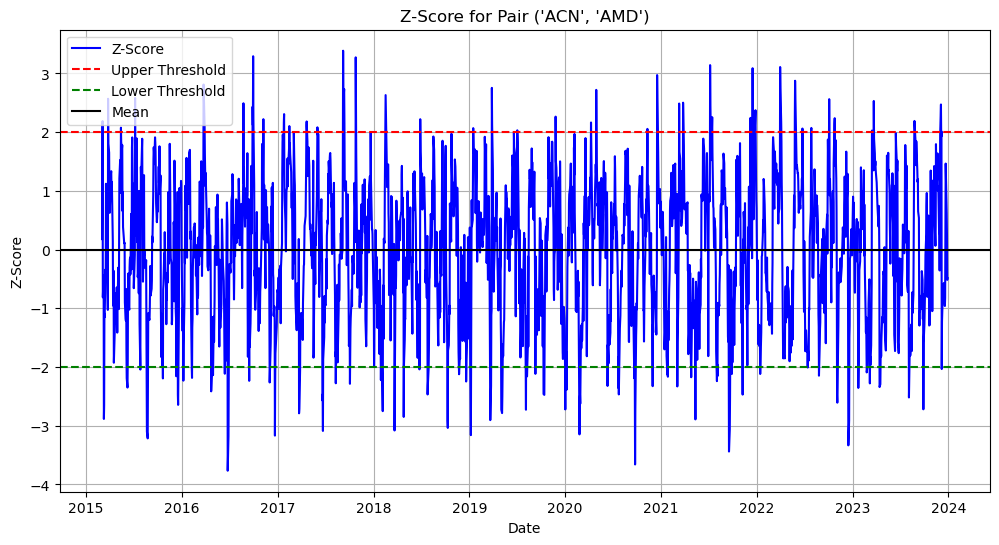

In [18]:
selected_pair = best_results_df.iloc[0]['Pair']
S1, S2 = selected_pair
pair_data = data[[S1, S2]].dropna()
Y = pair_data[S1]
X = sm.add_constant(pair_data[S2])
rolling_model = RollingOLS(Y, X, window=21)
rolling_results = rolling_model.fit()
hedge_ratios = rolling_results.params[S2]
intercepts = rolling_results.params['const']
spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
spread_mean = spread.rolling(window=21).mean()
spread_std = spread.rolling(window=21).std()
zscore = (spread - spread_mean) / spread_std

plt.figure(figsize=(12, 6))
plt.plot(zscore, label='Z-Score', color='blue')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(0, color='black', linestyle='-', label='Mean')
plt.title(f"Z-Score for Pair {selected_pair}")
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()


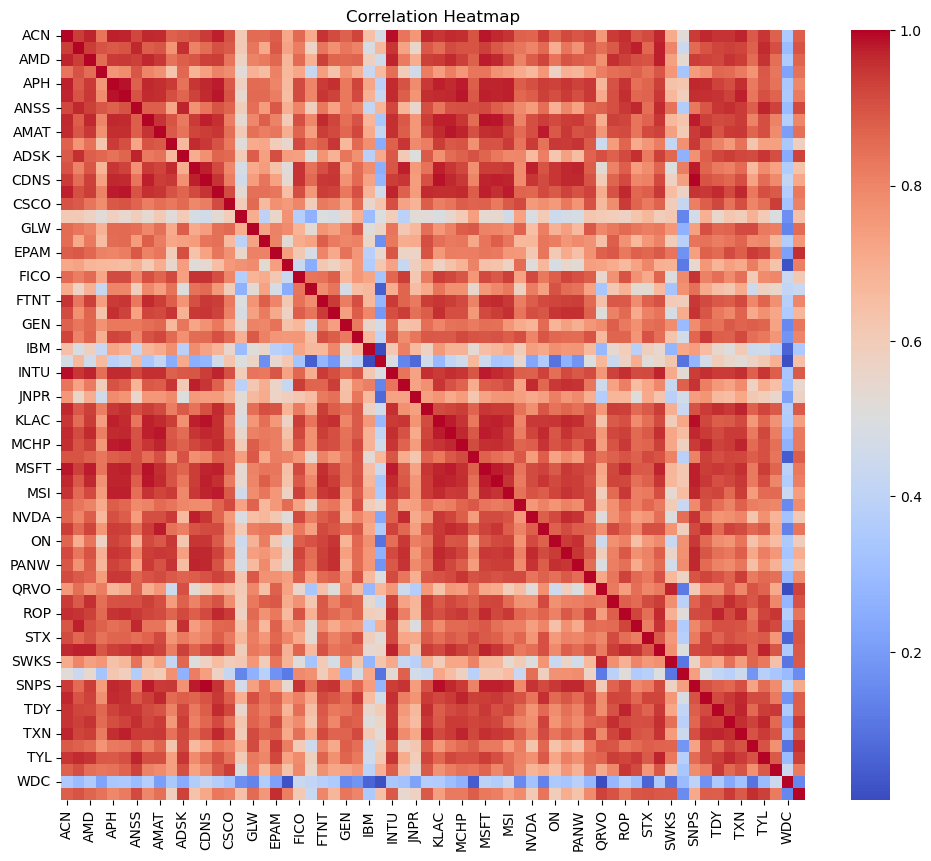

In [19]:
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()